<a href="https://colab.research.google.com/github/zrosen3/W207-Spring-2023/blob/main/Assignment_9_Rosen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9

In this lab, we'll train models for sentiment classification and experiment with learned embeddings for text features.

In [2]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style
import plotly.graph_objs as plotly  # for interactive plots

import tensorflow as tf
from tensorflow.keras.datasets import imdb

## Data for Sentiment Classification

In this lab, we'll train a *sentiment* classifier for movie reviews. That is, the input is the text of a movie review and the output is the probability the input was a positive review. The target labels are binary, 0 for negative and 1 for positive.

Our data includes 50,000 movie reviews on IMDB. The data comes pre-segmented into train and test splits. The [data loading function](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb/load_data) below also splits each input text into tokens (words) and maps the words to integer values. Each input is a sequence of integers corresponding to the words.

In [3]:
(X_train, Y_train), (X_test, Y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=None,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)

print("X_train.shape:", X_train.shape)
print("Y_train.shape:", Y_train.shape)
print("X_test.shape:", X_test.shape)
print("Y_test.shape:", Y_test.shape)

print('First training example data:', X_train[0])
print('First training example label:', Y_train[0])

17464789/17464789 [==============================] - 0s 0us/step
X_train.shape: (25000,)
Y_train.shape: (25000,)
X_test.shape: (25000,)
Y_test.shape: (25000,)
First training example data: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 48

So our first training example is a positive review. But that sequence of integer IDs is hard to read. The data loader provides a dictionary mapping words to IDs. Let's create a reverse index.


In [4]:
# The imdb dataset comes with an index mapping words to integers.
# In the index the words are ordered by frequency they occur.
index = imdb.get_word_index()

# Because we used index_from=3 (above), setting aside ids below 3 for special
# symbols, we need to add 3 to the index values.
index = dict([(key, value+3) for (key, value) in index.items()])

# Create a reverse index so we can lookup tokens assigned to each id.
reverse_index = dict([(value, key) for (key, value) in index.items()])
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'

max_id = max(reverse_index.keys())
print('Largest ID:', max_id)

1641221/1641221 [==============================] - 0s 0us/step
Largest ID: 88587


Note that our index (and reverse index) have over 88,000 tokens. That's quite a large vocabulary! Let's also write a decoding function for our data.

In [5]:
def decode(token_ids):
  """Return a string with the decoded text given a list of token ids."""
  # Try looking up each id in the index, but return '#' (for OOV) if not found.
  tokens = [reverse_index.get(i, "#") for i in token_ids]

  # Connect the string tokens with a space.
  return ' '.join(tokens)

# Show the ids corresponding tokens in the first example.
print(X_train[0])
print(decode(X_train[0]))

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
<START> this film was just brilliant

### Text Lengths
As usual, let's start with some data analysis. How long are the reviews? Is there a difference in length between positive and negative reviews? A histogram will help answer these questions.

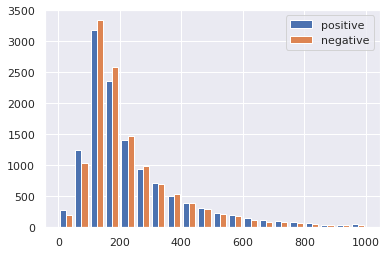

Longest positive review: 2494
Longest negative review: 1571


In [6]:
# Create a list of lengths for training examples with a positive label.
text_lengths_pos = [len(x) for (i, x) in enumerate(X_train) if Y_train[i]]

# And a list of lengths for training examples with a negative label.
text_lengths_neg = [len(x) for (i, x) in enumerate(X_train) if not Y_train[i]]

# The histogram function can take a list of inputs and corresponding labels.
plt.hist([text_lengths_pos, text_lengths_neg], bins=20, range=(0, 1000),
         label=['positive', 'negative'])
plt.legend()
plt.show()

# Also check the longest reviews.
print('Longest positive review:', max(text_lengths_pos))
print('Longest negative review:', max(text_lengths_neg))

---
### Exercise 1: Token Counts (8 points)
For each of the given tokens, construct a table with the number of positive training examples that include that token and the number of negative training examples that include that token. For reference, here are the counts for the first two tokens:

|Token|Pos Count|Neg Count|
|-|-|-|
|good|4767|4849|
|bad|1491|4396|

In [7]:
tokens = ['good', 'bad', 'amazing', 'boring', 'laugh', 'cry']
text_lengths_pos = [len(x) for (i, x) in enumerate(X_train) if Y_train[i]]
# And a list of lengths for training examples with a negative label.
text_lengths_neg = [len(x) for (i, x) in enumerate(X_train) if not Y_train[i]]
# YOUR CODE HERE
#Initialize a list to store tokens, counts
l = list()
for token in tokens:
  token_index = index[token]
  #find positive and negative examples with token
  training_exs_pos = [example for (index, example) in enumerate(X_train) if token_index in example and Y_train[index]]
  training_exs_neg = [example for (index, example) in enumerate(X_train) if token_index in example and not Y_train[index]]
  #count number of positive and negative examples with token
  pos_count = len(training_exs_pos)
  neg_count = len(training_exs_neg)
  #Add token, positive count, negative count to list 
  l.append([token, pos_count, neg_count])
#Convert list to table and print
df = pd.DataFrame(l, columns = ["Token", "Pos Count", "Neg Count"])
print(df)


     Token  Pos Count  Neg Count
0     good       4767       4849
1      bad       1491       4396
2  amazing        868        240
3   boring        301       1205
4    laugh        525        685
5      cry        231        114


---

## Feature Representation
Consider the difference between the pixel features we used for image classification and the text features we are now dealing with.

An image had 784 pixel positions. At each position, there is a single value in [0,1] (after normalization).

In contrast, a review has a variable number of ordered tokens (up to 2494 in the training examples). Each token occurs in a particular position. We can think of the token positions much like the 784 pixel positions, except that some of the trailing positions are empty, since review lengths vary.  At each token position, there is a single token, one of the 88587 entries in the vocabulary. So we can think of a review as a (2500, 90000) matrix: At each of ~2500 token positions, we have 1 of ~90000 token ids.

This representation would have 2500 * 90000 = 225 million features -- quite a lot more complexity than the images, though as you'll see below, we will make some simplifying assumptions, reducing both the number of token positions and the number of vocabulary items.

### Padding and Reduced Length
As is clear from the length histogram, the current representation of the review text is a variable-length array. Since fixed-length arrays are easier to work with in Tensorflow, let's add special padding tokens at the end of each review until they are all the same length.

We'll also use this operation to limit the number of token positions by truncating all reviews to a specified length. In the code below, as an example, we pad all training inputs to length 300.

In [8]:
def pad_data(sequences, max_length):
  # Keras has a convenient utility for padding a sequence.
  # Also make sure we get a numpy array rather than an array of lists.
  return np.array(list(
      tf.keras.preprocessing.sequence.pad_sequences(
          sequences, maxlen=max_length, padding='post', value=0)))

# Pad and truncate to 300 tokens.
X_train_padded = pad_data(X_train, max_length=300)

# Check the padded output.
print('Length of X_train[0]:', len(X_train[0]))
print('Length of X_train_padded[0]:', len(X_train_padded[0]))
print(X_train_padded[0])

Length of X_train[0]: 218
Length of X_train_padded[0]: 300
[    1    14    22    16    43   530   973  1622  1385    65   458  4468
    66  3941     4   173    36   256     5    25   100    43   838   112
    50   670 22665     9    35   480   284     5   150     4   172   112
   167 21631   336   385    39     4   172  4536  1111    17   546    38
    13   447     4   192    50    16     6   147  2025    19    14    22
     4  1920  4613   469     4    22    71    87    12    16    43   530
    38    76    15    13  1247     4    22    17   515    17    12    16
   626    18 19193     5    62   386    12     8   316     8   106     5
     4  2223  5244    16   480    66  3785    33     4   130    12    16
    38   619     5    25   124    51    36   135    48    25  1415    33
     6    22    12   215    28    77    52     5    14   407    16    82
 10311     8     4   107   117  5952    15   256     4 31050     7  3766
     5   723    36    71    43   530   476    26   400   317    4

### Reduced Vocabulary
We also want to be able to limit the vocabulary size. Since our padding function produces fixed-length sequences in a numpy matrix, we can use clever numpy indexing to efficiently replace all token ids larger than some value with the designated out-of-vocabulary (OOV) id.

In the code below, as an example, we'll keep just token ids less than 1000, replacing all others with OOV.

In [9]:
def limit_vocab(sequences, max_token_id, oov_id=2):
  """Replace token ids greater than or equal to max_token_id with the oov_id."""
  reduced_sequences = np.copy(sequences)
  reduced_sequences[reduced_sequences >= max_token_id] = oov_id
  return reduced_sequences

# Reduce vocabulary to 1000 tokens.
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
print(X_train_reduced[0])

# Decode to see what this looks like in tokens. Note the '#' for OOVs.
print(decode(X_train_reduced[0]))

[  1  14  22  16  43 530 973   2   2  65 458   2  66   2   4 173  36 256
   5  25 100  43 838 112  50 670   2   9  35 480 284   5 150   4 172 112
 167   2 336 385  39   4 172   2   2  17 546  38  13 447   4 192  50  16
   6 147   2  19  14  22   4   2   2 469   4  22  71  87  12  16  43 530
  38  76  15  13   2   4  22  17 515  17  12  16 626  18   2   5  62 386
  12   8 316   8 106   5   4   2   2  16 480  66   2  33   4 130  12  16
  38 619   5  25 124  51  36 135  48  25   2  33   6  22  12 215  28  77
  52   5  14 407  16  82   2   8   4 107 117   2  15 256   4   2   7   2
   5 723  36  71  43 530 476  26 400 317  46   7   4   2   2  13 104  88
   4 381  15 297  98  32   2  56  26 141   6 194   2  18   4 226  22  21
 134 476  26 480   5 144  30   2  18  51  36  28 224  92  25 104   4 226
  65  16  38   2  88  12  16 283   5  16   2 113 103  32  15  16   2  19
 178  32   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   

### One-hot Encoding
Our current feature representations are **sparse**. That is, we only keep track of the token ids that are present in the input. A **one-hot** encoding replaces a value like 22 (corresponding to 'film') with an array with a single 1 at position 22 and zeros everywhere else. This will be very memory-inefficient, but we'll do it anyway for clarity.

As discussed above, let's dramatically reduce both the number of token positions (review length) and the number of token ids (vocabulary). We'll clip each review after 20 tokens (so 2500 -> 20) and keep only the most common 1000 tokens (so 90000 -> 1000).

In [10]:
# Keras has a util to create one-hot encodings.
X_train_padded = pad_data(X_train, max_length=20)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=1000)
X_train_one_hot = tf.keras.utils.to_categorical(X_train_reduced)
print('X_train_one_hot shape:', X_train_one_hot.shape)

X_train_one_hot shape: (25000, 20, 1000)


Note the shape of the one-hot encoded features. For each of our 25000 training examples, we have a 20 x 1000 matrix. That is, for each of 20 token positions, we have a vector of 1000 elements containing a single 1 and 999 zeros.

We can think of these 1000-dimensional one-hot arrays as **embeddings**. Each token in the input has a 1000-dimensional representation. But because of the one-hot setup, the distance between each pair of tokens is the same ([1,0,0,...], [0,1,0,...], etc.). By contrast, learned embeddings result in meaningful distances between pairs of tokens. We'll get to that soon.

## Logistic Regression with One-Hot Encodings
Let's start with something familiar -- logistic regression. Since our feature representation is in 2 dimensions (20 x 1000), we need to flatten it to pass it to Keras (remember we did this with the pixel data too). Let's try two strategies for flattening.

1. Flatten by *concatenating* (as we did with pixels), turning (20 x 1000) data into (20000,) data. The result is a separate feature for each token at each position.
2. Flatten by *averaging* over token positions, turning (20 x 1000) data into (1000,) data. The result is an array with average token counts, ignoring position.

NOTE: Our prior assignments have used the standard Stochastic Gradient Descent (SGD) optimizer to compute the gradient from an estimate of the loss (based on the current mini-batch). There are many alternative optimizers. Here we'll use the **Adam** optimizer, which sometimes gives better results. One key characteristic of Adam is that it effectively uses a different learning rate for each parameter rather than a fixed learning rate as in SGD.

In [11]:
def build_onehot_model(average_over_positions=False):
  """Build a tf.keras model for one-hot data."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer='adam',             # fancy optimizer
                metrics=['accuracy'])

  return model

Now let's try fitting the model to our training data and check performance metrics on the validation (held-out) data. But first, here's a function for plotting the learning curves given the training history object we get from Keras.

In [12]:
def plot_history(history):
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.xticks(range(0, len(history['loss'] + 1)))
  plt.plot(history['loss'], label="training", marker='o')
  plt.plot(history['val_loss'], label="validation", marker='o')
  plt.legend()
  plt.show()

Epoch 1/5
352/352 [==============================] - 3s 7ms/step - loss: 0.6792 - accuracy: 0.6066 - val_loss: 0.6668 - val_accuracy: 0.6524
Epoch 2/5
352/352 [==============================] - 2s 6ms/step - loss: 0.6339 - accuracy: 0.7439 - val_loss: 0.6461 - val_accuracy: 0.6680
Epoch 3/5
352/352 [==============================] - 2s 7ms/step - loss: 0.5972 - accuracy: 0.7751 - val_loss: 0.6299 - val_accuracy: 0.6812
Epoch 4/5
352/352 [==============================] - 2s 7ms/step - loss: 0.5670 - accuracy: 0.7957 - val_loss: 0.6187 - val_accuracy: 0.6768
Epoch 5/5
352/352 [==============================] - 2s 6ms/step - loss: 0.5413 - accuracy: 0.8087 - val_loss: 0.6095 - val_accuracy: 0.6812


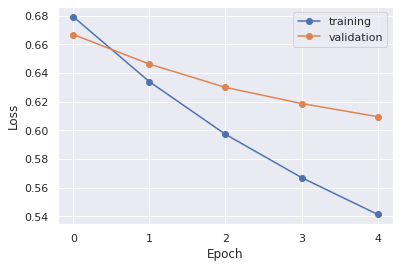

In [13]:
model = build_onehot_model()

# Fit the model.
history = model.fit(
  x = X_train_one_hot,  # one-hot training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

# Convert the return value into a DataFrame so we can see the train loss 
# and binary accuracy after every epoch.
history = pd.DataFrame(history.history)
plot_history(history)

---
### Exercise 2: Comparing logistic regrerssion models (8 points)
Train the one-hot model using both the concatenating and the averaging strategies and compare the results. Let's call these *LR-C* (Logistic Regression Concatenating) and *LR-A* (Logistic Regression Averaging). Then answer the following questions:

1. What are the final training and validation accuracies for LR-C and LR-A?
2. How many parameters are there in each model?
3. Would you say that either model is overfitting? Why or why not?
4. Briefly describe how LR-C differs from LR-A. How do you explain the relationship between their respective validation accuracy results? 

Epoch 1/10
352/352 [==============================] - 3s 8ms/step - loss: 0.6789 - accuracy: 0.6098 - val_loss: 0.6662 - val_accuracy: 0.6448
Epoch 2/10
352/352 [==============================] - 2s 7ms/step - loss: 0.6336 - accuracy: 0.7407 - val_loss: 0.6456 - val_accuracy: 0.6688
Epoch 3/10
352/352 [==============================] - 3s 7ms/step - loss: 0.5969 - accuracy: 0.7750 - val_loss: 0.6294 - val_accuracy: 0.6748
Epoch 4/10
352/352 [==============================] - 2s 6ms/step - loss: 0.5668 - accuracy: 0.7959 - val_loss: 0.6181 - val_accuracy: 0.6780
Epoch 5/10
352/352 [==============================] - 2s 6ms/step - loss: 0.5411 - accuracy: 0.8093 - val_loss: 0.6090 - val_accuracy: 0.6804
Epoch 6/10
352/352 [==============================] - 2s 6ms/step - loss: 0.5190 - accuracy: 0.8194 - val_loss: 0.6019 - val_accuracy: 0.6836
Epoch 7/10
352/352 [==============================] - 2s 6ms/step - loss: 0.4995 - accuracy: 0.8294 - val_loss: 0.5962 - val_accuracy: 0.6880
Epoch 

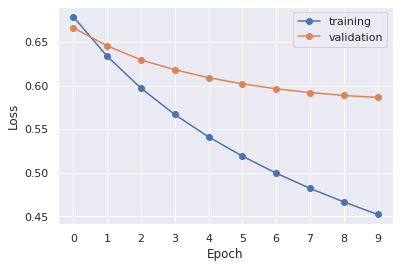

       loss  accuracy  val_loss  val_accuracy
0  0.678857  0.609778  0.666160        0.6448
1  0.633609  0.740711  0.645570        0.6688
2  0.596942  0.775022  0.629371        0.6748
3  0.566787  0.795867  0.618141        0.6780
4  0.541124  0.809289  0.608965        0.6804
5  0.519048  0.819378  0.601899        0.6836
6  0.499509  0.829378  0.596247        0.6880
7  0.482116  0.836578  0.591982        0.6916
8  0.466510  0.844400  0.588573        0.6948
9  0.452224  0.850000  0.586341        0.6964
Model parameters: 20001
LR-A model


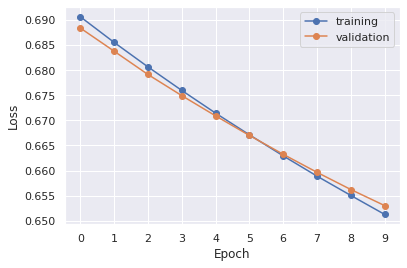

       loss  accuracy  val_loss  val_accuracy
0  0.690668  0.592178  0.688418        0.6268
1  0.685553  0.664622  0.683801        0.6612
2  0.680668  0.671867  0.679152        0.6824
3  0.675975  0.693600  0.674940        0.6884
4  0.671446  0.696933  0.670899        0.6900
5  0.667123  0.699111  0.666998        0.6924
6  0.662922  0.700622  0.663234        0.6892
7  0.658876  0.703956  0.659635        0.6924
8  0.655025  0.704400  0.656207        0.6952
9  0.651242  0.705600  0.652999        0.6980
Model parameters: 1001


In [14]:
#Train LR-C and LR-A model
concat_model = build_onehot_model(average_over_positions = False) #lrc
avg_model = build_onehot_model(average_over_positions = True) #lra

#Fit each model
concat_history = concat_model.fit(
  x = X_train_one_hot,  
  y = Y_train,          
  epochs=10,             
  batch_size=64,        
  validation_split=0.1,
  verbose=1             
  )

avg_history = avg_model.fit(
  x = X_train_one_hot,  
  y = Y_train,          
  epochs=10,             
  batch_size=64,        
  validation_split=0.1,
  verbose=1             
  )

# Print results
concat_history = pd.DataFrame(concat_history.history)
avg_history = pd.DataFrame(avg_history.history)
print("LR-C model results")
plot_history(concat_history)
print(concat_history)
print("Model parameters: " + str(concat_model.count_params()))
print("LR-A model")
plot_history(avg_history)
print(avg_history)
print("Model parameters: " + str(avg_model.count_params()))



*Written answers:*

1. The final training accuracy for LR-C is 85.00% and the final training accuracy for LR-A is 70.56%. 
2. There are 20,001 parameters in the LR-C model and 1,001 parameters in the LR-A model.
3. LR-A model is not overfitting because the training and validation loss continue to drop significantly through all epochs of training. The LR-C model is overfitting because the validation loss eventually plateaus while the training loss continues decreasing.
4. LR-C flattens the inputs of the first layer by concatenating and creating columns for each token at each position. LR-A averages the tokens across each positions to create features which represent each token's average prevalence in the input. The LR-C overfits the data by memorizing noisy relationships between tokens at indidual positions and labels. LR-A does not overfit because the average occurence of each token more closely corresponds to the token's impact on the label. The LR-C's overffiting causes its validation accuracy to be lower than that of the LR-A model.

---

## Logistic Regression with Embeddings
Next, let's train model that replaces one-hot representations of each token with learned embeddings.

The code below uses a Keras Embedding layer, which expects to receive a sparse (rather than one-hot) representation. That is, it expects a (padded) sequence of token ids; for each id, it looks up the corresponding embedding vector.

In [15]:
def build_embeddings_model(average_over_positions=False,
                           vocab_size=1000,
                           sequence_length=20,
                           embedding_dim=2):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  if average_over_positions:
    # This layer averages over the first dimension of the input by default.
    model.add(tf.keras.layers.GlobalAveragePooling1D())
  else:
    # Concatenate.
    model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(
      units=1,                     # output dim (for binary classification)
      activation='sigmoid'         # apply the sigmoid function!
  ))

  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

Try training the model as before. We'll use the averaging strategy rather than the concatenating strategy for dealing with the token sequence. That is, we'll look up embedding vectors for each token. Then we'll average them to produce a single vector. Then we'll traing a logistic regression with that vector as input to predict the binary label.

Epoch 1/5
352/352 [==============================] - 2s 3ms/step - loss: 0.6884 - accuracy: 0.6262 - val_loss: 0.6820 - val_accuracy: 0.6592
Epoch 2/5
352/352 [==============================] - 1s 2ms/step - loss: 0.6700 - accuracy: 0.6879 - val_loss: 0.6601 - val_accuracy: 0.6836
Epoch 3/5
352/352 [==============================] - 1s 2ms/step - loss: 0.6435 - accuracy: 0.7011 - val_loss: 0.6342 - val_accuracy: 0.6996
Epoch 4/5
352/352 [==============================] - 1s 2ms/step - loss: 0.6163 - accuracy: 0.7141 - val_loss: 0.6114 - val_accuracy: 0.7040
Epoch 5/5
352/352 [==============================] - 1s 2ms/step - loss: 0.5923 - accuracy: 0.7192 - val_loss: 0.5928 - val_accuracy: 0.7120


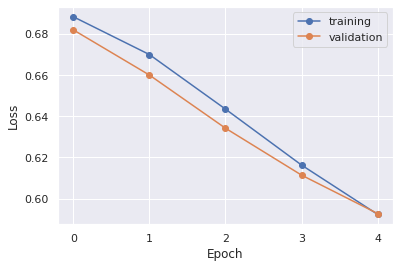

In [16]:
model = build_embeddings_model(average_over_positions=True,
                               vocab_size=1000,
                               sequence_length=20,
                               embedding_dim=2)
history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )

history = pd.DataFrame(history.history)
plot_history(history)

---
### Exercise 3: Experiments with embeddings (8 points)
Train 6 models with embedding sizes in [2,4,8,16,32,64], keeping other settings fixed. Use the averaging strategy rather than the concatenating strategy.

1. Construct a table with the training and validation accuracies of each model (after 5 training epochs).
2. Compute the number of parameters in each model.
3. Do learned embeddings appear to provide improved performance over the one-hot encoding? Why?

Model with 2 embeddings
Number of parameters: 2041
Epoch 1/5
352/352 [==============================] - 2s 3ms/step - loss: 0.6919 - accuracy: 0.5233 - val_loss: 0.6879 - val_accuracy: 0.5720
Epoch 2/5
352/352 [==============================] - 1s 2ms/step - loss: 0.6679 - accuracy: 0.6454 - val_loss: 0.6429 - val_accuracy: 0.6644
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5974 - accuracy: 0.7069 - val_loss: 0.5802 - val_accuracy: 0.6996
Epoch 4/5
352/352 [==============================] - 1s 4ms/step - loss: 0.5424 - accuracy: 0.7350 - val_loss: 0.5513 - val_accuracy: 0.7148
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5142 - accuracy: 0.7470 - val_loss: 0.5378 - val_accuracy: 0.7208


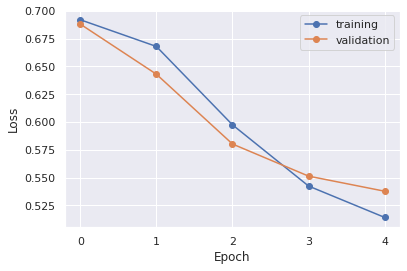

Model with 4 embeddings
Number of parameters: 4081
Epoch 1/5
352/352 [==============================] - 2s 3ms/step - loss: 0.6802 - accuracy: 0.6018 - val_loss: 0.6504 - val_accuracy: 0.6676
Epoch 2/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5893 - accuracy: 0.7167 - val_loss: 0.5603 - val_accuracy: 0.7120
Epoch 3/5
352/352 [==============================] - 1s 2ms/step - loss: 0.5239 - accuracy: 0.7427 - val_loss: 0.5353 - val_accuracy: 0.7228
Epoch 4/5
352/352 [==============================] - 1s 2ms/step - loss: 0.4997 - accuracy: 0.7552 - val_loss: 0.5288 - val_accuracy: 0.7296
Epoch 5/5
352/352 [==============================] - 1s 4ms/step - loss: 0.4883 - accuracy: 0.7620 - val_loss: 0.5261 - val_accuracy: 0.7292


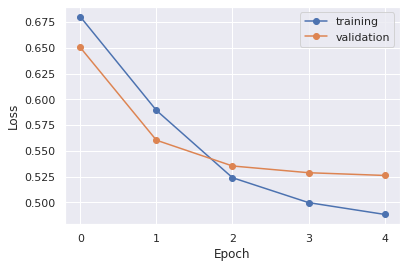

Model with 8 embeddings
Number of parameters: 8161
Epoch 1/5
352/352 [==============================] - 2s 5ms/step - loss: 0.6755 - accuracy: 0.6103 - val_loss: 0.6334 - val_accuracy: 0.6760
Epoch 2/5
352/352 [==============================] - 1s 4ms/step - loss: 0.5662 - accuracy: 0.7263 - val_loss: 0.5452 - val_accuracy: 0.7212
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5070 - accuracy: 0.7518 - val_loss: 0.5289 - val_accuracy: 0.7296
Epoch 4/5
352/352 [==============================] - 1s 2ms/step - loss: 0.4852 - accuracy: 0.7661 - val_loss: 0.5260 - val_accuracy: 0.7332
Epoch 5/5
352/352 [==============================] - 1s 2ms/step - loss: 0.4726 - accuracy: 0.7716 - val_loss: 0.5261 - val_accuracy: 0.7324


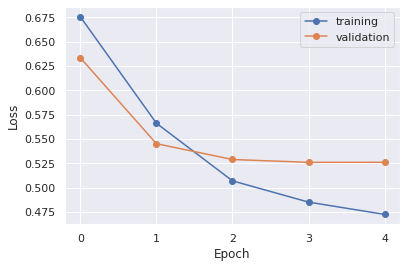

Model with 16 embeddings
Number of parameters: 16321
Epoch 1/5
352/352 [==============================] - 4s 6ms/step - loss: 0.6660 - accuracy: 0.6250 - val_loss: 0.6081 - val_accuracy: 0.6908
Epoch 2/5
352/352 [==============================] - 2s 5ms/step - loss: 0.5406 - accuracy: 0.7380 - val_loss: 0.5352 - val_accuracy: 0.7228
Epoch 3/5
352/352 [==============================] - 2s 5ms/step - loss: 0.4896 - accuracy: 0.7625 - val_loss: 0.5263 - val_accuracy: 0.7296
Epoch 4/5
352/352 [==============================] - 2s 6ms/step - loss: 0.4657 - accuracy: 0.7779 - val_loss: 0.5263 - val_accuracy: 0.7280
Epoch 5/5
352/352 [==============================] - 2s 6ms/step - loss: 0.4475 - accuracy: 0.7876 - val_loss: 0.5303 - val_accuracy: 0.7268


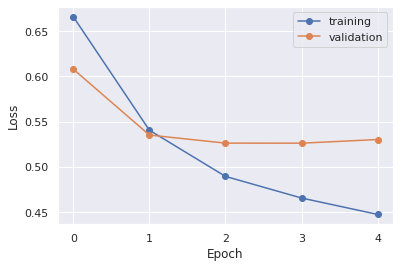

Model with 32 embeddings
Number of parameters: 32641
Epoch 1/5
352/352 [==============================] - 3s 3ms/step - loss: 0.6509 - accuracy: 0.6343 - val_loss: 0.5765 - val_accuracy: 0.7028
Epoch 2/5
352/352 [==============================] - 1s 3ms/step - loss: 0.5175 - accuracy: 0.7493 - val_loss: 0.5306 - val_accuracy: 0.7280
Epoch 3/5
352/352 [==============================] - 1s 3ms/step - loss: 0.4740 - accuracy: 0.7716 - val_loss: 0.5302 - val_accuracy: 0.7328
Epoch 4/5
352/352 [==============================] - 1s 3ms/step - loss: 0.4457 - accuracy: 0.7901 - val_loss: 0.5361 - val_accuracy: 0.7280
Epoch 5/5
352/352 [==============================] - 1s 3ms/step - loss: 0.4204 - accuracy: 0.8068 - val_loss: 0.5476 - val_accuracy: 0.7204


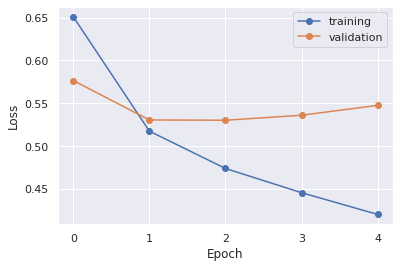

Model with 64 embeddings
Number of parameters: 65281
Epoch 1/5
352/352 [==============================] - 2s 4ms/step - loss: 0.6344 - accuracy: 0.6454 - val_loss: 0.5517 - val_accuracy: 0.7172
Epoch 2/5
352/352 [==============================] - 1s 4ms/step - loss: 0.5014 - accuracy: 0.7556 - val_loss: 0.5260 - val_accuracy: 0.7300
Epoch 3/5
352/352 [==============================] - 1s 4ms/step - loss: 0.4577 - accuracy: 0.7838 - val_loss: 0.5322 - val_accuracy: 0.7240
Epoch 4/5
352/352 [==============================] - 1s 4ms/step - loss: 0.4180 - accuracy: 0.8092 - val_loss: 0.5454 - val_accuracy: 0.7196
Epoch 5/5
352/352 [==============================] - 1s 4ms/step - loss: 0.3797 - accuracy: 0.8338 - val_loss: 0.5668 - val_accuracy: 0.7188


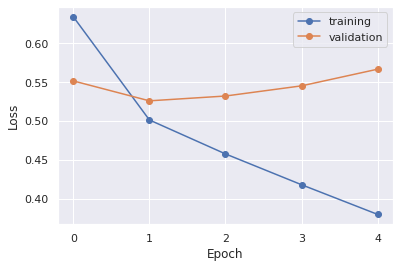

In [17]:
#Train models with multiple embedding sizes using the averaging strategy
sizes = [2, 4, 8, 16, 32, 64]
for size in sizes:
  print("Model with " + str(size) + " embeddings")
  model = build_embeddings_model(embedding_dim = size)
  print("Number of parameters:", str(model.count_params()))
  history = model.fit(
  x = X_train_reduced,  # our sparse padded training data
  y = Y_train,          # corresponding binary labels
  epochs=5,             # number of passes through the training data
  batch_size=64,        # mini-batch size
  validation_split=0.1, # use a fraction of the examples for validation
  verbose=1             # display some progress output during training
  )
  history = pd.DataFrame(history.history)
  plot_history(history)


*Written answers:*

1. Training and validation accuracies for each model after 5 epochs:

| Model embedding size | Training accuracy | Validation accuracy |
|----------------------|-------------------|---------------------|
|   2                  |   .7470           |   .7208             |
|   4                  |   .7620           |   .7292             |
|   8                  |   .7716           |   .7324             |  
|   16                 |   .7876           |   .7268             |
|   32                 |   .8068           |   .7204             |
|   64                 |   .8338           |   .7188             |


2. The number of parameters in each model with the corresponding size are as follows:

Size 2: 2,041

Size 4: 4,081

Size 8: 8,161

Size 16: 16,321

Size 32: 32,641

Size 64: 65, 281


3. Learned embeddings do appear to show improved performance to one hot encoding. Validation accuracy for the one-hot encoding models is never higher than 70%, and all the embedding models yield validation accuracy greater than 70%. The embeddings better capture the relationship between words, where one-hot encoding treats each token as independent. The one-hot encoded data also has reduced noise and dimensionality, and ultimately generalizes better to the validation data to produce better results.

---

## Inspecting Learned Embeddings
Let's retrieve the learned embedding parameters from the trained model and plot the token embeddings.

The model layers in a Keras Sequential model are stored as a list and the embeddings are the first layer. We can use the get_weights() function to get a numpy array with the parameters.

In [18]:
# Display the model layers.
display(model.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings = model.layers[0].get_weights()[0]
display(embeddings.shape)

(1000, 64)

Now we'll use a fancy plotting tool called *plotly* to show the embeddings with hovertext so you can move your mouse over the points to see the corresponding tokens.

In [19]:
def plot_2d_embeddings(embeddings, id_start=1, count=100):
  # Get 1st and 2nd embedding dims for the desired tokens.
  x1 = embeddings[id_start:id_start+count, 0]
  x2 = embeddings[id_start:id_start+count, 1]
  
  # Get the corresponding words from the reverse index (for labeling).
  tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

  # Plot with the plotly library.
  data = plotly.Scatter(x=x1, y=x2, text=tokens,
                        mode='markers', textposition='bottom left',
                        hoverinfo='text')
  fig = plotly.Figure(data=[data],
                      layout=plotly.Layout(title="Word Embeddings",
                                           hovermode='closest'))
  fig.show()

# Very frequent tokens tend to be more syntactic than semantic, so let's plot
# some rarer words.    
plot_2d_embeddings(embeddings, id_start=500, count=500)

---
### Exercise 4: Interpretting Embeddings (8 points)
Notice that the 2-D embeddings fall in a narrow diagonal band.

1. Have the learned embeddings separated positive and negative words? What is the most negative word? Does this make sense?
2. Give 2 examples of words that seem to have surprising embedding values and try to explain their positions. For example, what's going on with the tokens '7', '8', and '9'?
3. The embedding for 'crazy' is very close to (0,0). Explain what this means in terms of the model's output.
4. Can you explain what you think the 2 learned embedding dimensions mean, if anything?

*Written answers:*

1. The learned embeddings separate positive and negative words. Positive words tend to be located towards the top left, while negative words are found towards the bottom right. Words that are either neutral or could be positive or negative are in the middle. "Lame" is at the bottom right corner and appears to be the most negative word, which makes sense because lame is typically associated with a negative sentiment. 

2. "Free" seems to be located near "horrible" and "avoid" which is surprising, because "free" is not a word I would typically associate with a negative review. It is possible that a lot of the reviews said something like the "movie should have been free" for negative reviews. 

  "Peter" appears towards the top left of the graph around other positive words. Perhaps there are several movies involving characters named Peter such as Peter Parker and Peter Pan that were reviewed positively.

  "7", "8" and "9" are all located near the top left of the graph, which means they are highly positive words. "7", "8", "9" likely appear when the reviewer is rating movies out of 10, so it makes sense that these numbers are associated with a positive sentiment. 

3. The embedding for 'crazy' being close to (0,0) means that it is not clearly associated with either positive or negative sentimenet. 

4. Since the embeddings fall in a narrow diagonal band where the y values tend to be higher with lower x values, I know that the two dimensions are negatively correlated. I do not think the two embeddings mean anything easily interpretable but they are useful for separating positive and negative words. 


---

## Scaling Up!
Remember how we limited our input sequences to 20 tokens and 1000 vocabulary entries? Let's see how well we can do using more data and bigger models (more parameters).

### Exercise 5: Improve Results (8 points)
Using pieces of code from above, set up and train a model that improves the validation accuracy to at least 80%. You should include the following elements:

1. Truncate and pad input to the desired length.
2. Limit vocabulary to the desired size.
3. Set up a model using embeddings.
4. Add an additional layer or layers (after the embeddings layer and before the output layer).
5. Evaluate on the test data. Remember to apply the same pre-processing to the test data. You can use model.evaluate().

Epoch 1/5
352/352 [==============================] - 4s 8ms/step - loss: 0.5356 - accuracy: 0.7614 - val_loss: 0.3804 - val_accuracy: 0.8276
Epoch 2/5
352/352 [==============================] - 2s 6ms/step - loss: 0.3188 - accuracy: 0.8664 - val_loss: 0.3498 - val_accuracy: 0.8436
Epoch 3/5
352/352 [==============================] - 2s 7ms/step - loss: 0.2742 - accuracy: 0.8866 - val_loss: 0.3452 - val_accuracy: 0.8488
Epoch 4/5
352/352 [==============================] - 3s 9ms/step - loss: 0.2518 - accuracy: 0.8971 - val_loss: 0.3611 - val_accuracy: 0.8416
Epoch 5/5
352/352 [==============================] - 3s 10ms/step - loss: 0.2376 - accuracy: 0.9069 - val_loss: 0.3668 - val_accuracy: 0.8428


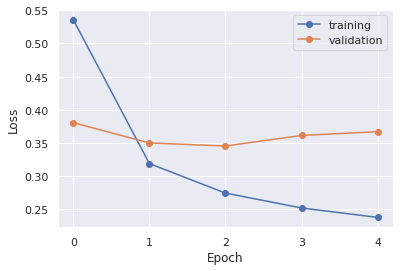

782/782 [==============================] - 1s 2ms/step - loss: 0.3673 - accuracy: 0.8458
[0.3673253059387207, 0.8457599878311157]


In [23]:
# YOUR CODE HERE
#1. Truncate and pad input to desired length
#clip each review after  tokens (max total 2500)
X_train_padded = pad_data(X_train, max_length=100) 
X_test_padded = pad_data(X_test, max_length = 100)

#2. Limit vocabulary to the desired length
#Keep only  most common 10000 tokens  (total 90000)
X_train_reduced = limit_vocab(X_train_padded, max_token_id=5000)
X_test_reduced = limit_vocab(X_test_padded, max_token_id=5000)

#3. Set up a model using embeddings
def build_custom_model(vocab_size=10000,
                           sequence_length=500,
                           embedding_dim=64):
  """Build a tf.keras model using embeddings."""
  # Clear session and remove randomness.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  #Embedding layer
  model.add(tf.keras.layers.Embedding(
      input_dim=vocab_size,
      output_dim=embedding_dim,
      input_length=sequence_length)
  )

  # Averaging layer
  model.add(tf.keras.layers.GlobalAveragePooling1D())

  #4. Add additional dense layer
  model.add(tf.keras.layers.Dense(units = 32, 
                                  activation = 'relu'))


  #Output layer
  model.add(tf.keras.layers.Dense(
      units=1,                     
      activation='sigmoid'         
  ))
  #Compile model
  model.compile(loss='binary_crossentropy', 
                optimizer='adam',
                metrics=['accuracy'])

  return model

model = build_custom_model(vocab_size=5000,
                           sequence_length=100,
                           embedding_dim=32)
history = model.fit(
  x = X_train_reduced,  
  y = Y_train,          
  epochs=5,            
  batch_size=64,        
  validation_split=0.1, 
  verbose=1             
  )

history = pd.DataFrame(history.history)
plot_history(history)

#5. Evaluate the model on test data 
print(model.evaluate(x = X_test_reduced, y= Y_test))